<a href="https://colab.research.google.com/github/jeanlucjackson/w266_final_project/blob/main/code/sandboxes/RR/rr_evaluation_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
evaluation_root = "/content/drive/MyDrive/w266 NLP Final Project/Evaluation/"
filename = evaluation_root + "evaluation_database.json"

# Read JSON into dataframe
evaluation_db_df = pd.read_json(filename)

In [36]:
evaluation_db_df.columns

Index(['prediction_set', 'target', 'prediction', 'rouge1', 'rouge2', 'rougeL',
       'rougeLsum', 'bleu', 'bleurt', 'bertscore-precision',
       'bertscore-recall', 'bertscore-f1', 'meteor', 'base_model',
       'trained_on', 'tested_on', 'nickname'],
      dtype='object')

In [37]:
pd.set_option('precision', 7)

In [38]:
evaluation_db_df[(evaluation_db_df['base_model'] == 'T5') &
                 (evaluation_db_df['trained_on'] == 'squad') &
                 (evaluation_db_df['tested_on'] == 'squad')
].groupby(['base_model', 'trained_on', 'tested_on']).mean()

,,,rouge1,rouge2,rougeL,rougeLsum,bleu,bleurt,bertscore-precision,bertscore-recall,bertscore-f1,meteor
base_model,trained_on,tested_on,,,,,,,,,,
T5,squad,squad,0.4841505,0.2683973,0.4520709,0.4520709,0.132327,-0.3186719,0.8713681,0.8597745,0.8649285,0.4554956


In [39]:
evaluation_db_df[evaluation_db_df['tested_on'] == 'nq'].groupby(['base_model', 'trained_on', 'tested_on']).mean().sort_values(by=['bertscore-f1'], ascending=False)

rouge1     rouge2     rougeL  rougeLsum  \
base_model trained_on tested_on                                               
bart       nq         nq         0.5764452  0.3570425  0.5504308  0.5504308   
           amalgam    nq         0.5693885  0.3531234  0.5450033  0.5450033   
T5         nq         nq         0.5439559  0.3213365  0.5190866  0.5190866   
           amalgam    nq         0.5459080  0.3218370  0.5201673  0.5201673   
bart       squad      nq         0.4287571  0.2126317  0.4105985  0.4105985   
T5         squad      nq         0.4251869  0.2080766  0.4064820  0.4064820   
bart       triviaqa   nq         0.4025288  0.1970966  0.3656208  0.3656208   
T5         triviaqa   nq         0.3156918  0.1313760  0.2722885  0.2722885   
bart       quac       nq         0.3341540  0.1369493  0.3261240  0.3261240   
T5         quac       nq         0.1491128  0.0239176  0.1448241  0.1448241   

                                      bleu     bleurt  bertscore-precision  \
base_model trained_on tested_on                                              
bart       nq         nq         0.2030720 -0.2507158            0.8706468   
           amalgam    nq         0.1966931 -0.2672042            0.8665410   
T5         nq         nq         0.1610354 -0.3686526            0.8616222   
           amalgam    nq         0.1613396 -0.3562101            0.8600889   
bart       squad      nq         0.0117933 -0.6329097            0.7928945   
T5         squad      nq         0.0119527 -0.6608551            0.7910331   
bart       triviaqa   nq         0.0114156 -0.7363415            0.7768211   
T5         triviaqa   nq         0.0058048 -0.9437208            0.7530847   
bart       quac       nq         0.0050415 -0.9908768            0.7599404   
T5         quac       nq         0.0001508 -1.5072225            0.6952467   

                                 bertscore-recall  bertscore-f1     meteor  
base_model trained_on tested_on                                             
bart       nq         nq                0.8646068     0.8674017  0.5288023  
           amalgam    nq                0.8626053     0.8643309  0.5235378  
T5         nq         nq                0.8523081     0.8566341  0.4916085  
           amalgam    nq                0.8533182     0.8563697  0.4940380  
bart       squad      nq                0.8051200     0.7986027  0.3553013  
T5         squad      nq                0.8026223     0.7964095  0.3519202  
bart       triviaqa   nq                0.8160979     0.7955905  0.3674436  
T5         triviaqa   nq                0.7891527     0.7701525  0.2916362  
bart       quac       nq                0.7419663     0.7505394  0.2243745  
T5         quac       nq                0.6813169     0.6880327  0.0761084

In [40]:
evaluation_db_df[evaluation_db_df['tested_on'] == 'quac'].groupby(['base_model', 'trained_on', 'tested_on']).mean().sort_values(by=['bertscore-f1'], ascending=False)

rouge1     rouge2     rougeL  rougeLsum  \
base_model trained_on tested_on                                               
bart       quac       quac       0.2866944  0.1403806  0.2827478  0.2827478   
T5         amalgam    quac       0.2572883  0.1026064  0.2521994  0.2521994   
bart       amalgam    quac       0.2380663  0.0883393  0.2336747  0.2336747   
T5         quac       quac       0.1720269  0.0410675  0.1710328  0.1710328   
           squad      quac       0.1897926  0.0451312  0.1837322  0.1837322   
bart       squad      quac       0.1892887  0.0466039  0.1841762  0.1841762   
           triviaqa   quac       0.1218770  0.0256229  0.1136716  0.1136716   
T5         triviaqa   quac       0.1098792  0.0193101  0.0989086  0.0989086   
bart       nq         quac       0.1529877  0.0346344  0.1496091  0.1496091   
T5         nq         quac       0.1539190  0.0339060  0.1502992  0.1502992   

                                      bleu     bleurt  bertscore-precision  \
base_model trained_on tested_on                                              
bart       quac       quac       0.0572199 -0.8082456            0.7963524   
T5         amalgam    quac       0.0290387 -0.9355374            0.7889416   
bart       amalgam    quac       0.0274114 -1.0443755            0.7585320   
T5         quac       quac       0.0025990 -1.3704631            0.7713364   
           squad      quac       0.0061944 -1.1584142            0.7355438   
bart       squad      quac       0.0071227 -1.2147635            0.7367573   
           triviaqa   quac       0.0014587 -1.3745412            0.6814375   
T5         triviaqa   quac       0.0009740 -1.3860679            0.6816795   
bart       nq         quac       0.0010830 -1.3413495            0.6925152   
T5         nq         quac       0.0010035 -1.3608657            0.6926564   

                                 bertscore-recall  bertscore-f1     meteor  
base_model trained_on tested_on                                             
bart       quac       quac              0.7902423     0.7928034  0.2880536  
T5         amalgam    quac              0.7822649     0.7850613  0.2550837  
bart       amalgam    quac              0.7842152     0.7705161  0.2501502  
T5         quac       quac              0.7499616     0.7600982  0.1653255  
           squad      quac              0.7750947     0.7542599  0.2095839  
bart       squad      quac              0.7732840     0.7539764  0.2058704  
           triviaqa   quac              0.7417137     0.7097454  0.1640066  
T5         triviaqa   quac              0.7362435     0.7073408  0.1496998  
bart       nq         quac              0.7024486     0.6971800  0.1126128  
T5         nq         quac              0.7007574     0.6963980  0.1113164

In [41]:
evaluation_db_df[evaluation_db_df['tested_on'] == 'squad'].groupby(['base_model', 'trained_on', 'tested_on']).mean().sort_values(by=['bertscore-f1'], ascending=False)

rouge1     rouge2     rougeL  rougeLsum  \
base_model trained_on tested_on                                               
bart       squad      squad      0.5034202  0.2902943  0.4691895  0.4691895   
T5         squad      squad      0.4841505  0.2683973  0.4520709  0.4520709   
bart       amalgam    squad      0.4933227  0.2793195  0.4585801  0.4585801   
T5         amalgam    squad      0.4876972  0.2687683  0.4551744  0.4551744   
bart       triviaqa   squad      0.3506784  0.1418476  0.3104080  0.3104080   
           quac       squad      0.3061604  0.1133183  0.2908981  0.2908981   
T5         triviaqa   squad      0.2938222  0.1058934  0.2426033  0.2426033   
           nq         squad      0.3576169  0.1440951  0.3300749  0.3300749   
bart       nq         squad      0.3490372  0.1390376  0.3226235  0.3226235   
T5         quac       squad      0.1799689  0.0252841  0.1734369  0.1734369   

                                      bleu     bleurt  bertscore-precision  \
base_model trained_on tested_on                                              
bart       squad      squad      0.1512423 -0.2669416            0.8752155   
T5         squad      squad      0.1323270 -0.3186719            0.8713681   
bart       amalgam    squad      0.1358131 -0.3080665            0.8690088   
T5         amalgam    squad      0.1252232 -0.3264827            0.8691292   
bart       triviaqa   squad      0.0470251 -0.6453968            0.8097612   
           quac       squad      0.0277197 -0.8318229            0.8331894   
T5         triviaqa   squad      0.0284907 -0.8792286            0.7839039   
           nq         squad      0.0140823 -0.7626005            0.8007723   
bart       nq         squad      0.0143855 -0.7647174            0.7975280   
T5         quac       squad      0.0009409 -1.3550282            0.7692503   

                                 bertscore-recall  bertscore-f1     meteor  
base_model trained_on tested_on                                             
bart       squad      squad             0.8650968     0.8695415  0.4753351  
T5         squad      squad             0.8597745     0.8649285  0.4554956  
bart       amalgam    squad             0.8579045     0.8628507  0.4601350  
T5         amalgam    squad             0.8562504     0.8620508  0.4530429  
bart       triviaqa   squad             0.8252261     0.8167537  0.3382058  
           quac       squad             0.7758945     0.8029487  0.2456101  
T5         triviaqa   squad             0.7999227     0.7909590  0.2893637  
           nq         squad             0.7728582     0.7862682  0.2593207  
bart       nq         squad             0.7711403     0.7838243  0.2520325  
T5         quac       squad             0.7168291     0.7416607  0.1343184

In [42]:
evaluation_db_df[evaluation_db_df['tested_on'] == 'triviaqa'].groupby(['base_model', 'trained_on', 'tested_on']).mean().sort_values(by=['bertscore-f1'], ascending=False)

rouge1     rouge2     rougeL  rougeLsum  \
base_model trained_on tested_on                                               
bart       amalgam    triviaqa   0.4357428  0.2213908  0.3687185  0.3687185   
           triviaqa   triviaqa   0.4340132  0.2187006  0.3677846  0.3677846   
T5         amalgam    triviaqa   0.4125915  0.1946350  0.3468133  0.3468133   
           triviaqa   triviaqa   0.3780013  0.1613003  0.3152998  0.3152998   
           squad      triviaqa   0.3098121  0.1093215  0.2667492  0.2667492   
bart       squad      triviaqa   0.2977691  0.1101429  0.2602665  0.2602665   
           nq         triviaqa   0.3318911  0.1285346  0.2864366  0.2864366   
T5         nq         triviaqa   0.3139721  0.1166649  0.2731159  0.2731159   
bart       quac       triviaqa   0.2187986  0.0625604  0.1978116  0.1978116   
T5         quac       triviaqa   0.1247759  0.0128405  0.1162006  0.1162006   

                                      bleu     bleurt  bertscore-precision  \
base_model trained_on tested_on                                              
bart       amalgam    triviaqa   0.0779728 -0.6264859            0.8438085   
           triviaqa   triviaqa   0.0760055 -0.6314416            0.8443769   
T5         amalgam    triviaqa   0.0586940 -0.6839826            0.8370901   
           triviaqa   triviaqa   0.0456115 -0.7718085            0.8256968   
           squad      triviaqa   0.0225060 -0.9153869            0.8140585   
bart       squad      triviaqa   0.0219294 -0.9087313            0.8152411   
           nq         triviaqa   0.0079975 -1.0173921            0.7999396   
T5         nq         triviaqa   0.0073187 -1.0623568            0.7917321   
bart       quac       triviaqa   0.0068680 -1.1691513            0.7999744   
T5         quac       triviaqa   0.0002378 -1.5220485            0.7418159   

                                 bertscore-recall  bertscore-f1     meteor  
base_model trained_on tested_on                                             
bart       amalgam    triviaqa          0.8113309     0.8264325  0.3545916  
           triviaqa   triviaqa          0.8097953     0.8259178  0.3510280  
T5         amalgam    triviaqa          0.8035584     0.8191091  0.3270014  
           triviaqa   triviaqa          0.7966459     0.8100851  0.2995307  
           squad      triviaqa          0.7652418     0.7881471  0.2255328  
bart       squad      triviaqa          0.7641784     0.7880865  0.2190747  
           nq         triviaqa          0.7446307     0.7708331  0.2008327  
T5         nq         triviaqa          0.7387747     0.7638598  0.1860087  
bart       quac       triviaqa          0.7167295     0.7554700  0.1509115  
T5         quac       triviaqa          0.6726109     0.7050298  0.0888562

In [ ]:
#rankorderofsomelist = [sorted(somelist).index(x) for x in somelist]
df = evaluation_db_df[evaluation_db_df['tested_on'] == 'triviaqa'].groupby(['base_model', 'trained_on', 'tested_on']).mean().sort_values(by=['bertscore-f1'], ascending=False)
vector_rouge1 = [sorted(df.rouge1, reverse=True).index(x) + 1 for x in df.rouge1]
vector_rouge1

In [44]:
vector_rouge2 = [sorted(df.rouge2, reverse=True).index(x) + 1 for x in df.rouge2]
vector_rouge2

[1, 2, 3, 4, 8, 7, 5, 6, 9, 10]

In [48]:
vector_rougeL = [sorted(df.rougeL, reverse=True).index(x) + 1 for x in df.rougeL]
vector_rougeL

[1, 2, 3, 4, 7, 8, 5, 6, 9, 10]

In [49]:
vector_bleurt = [sorted(df.bleurt, reverse=True).index(x) + 1 for x in df.bleurt]
vector_bleurt

[1, 2, 3, 4, 6, 5, 7, 8, 9, 10]

In [50]:
vector_bertscore_f1 = [sorted(df['bertscore-f1'], reverse=True).index(x) + 1 for x in df['bertscore-f1']]
vector_bertscore_f1

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [52]:
result = cosine_similarity([vector_rouge1, vector_rouge2, vector_rougeL, vector_bleurt, vector_bertscore_f1])
result

array([[1.        , 0.9974026 , 1.        , 0.97662338, 0.97922078],
       [0.9974026 , 1.        , 0.9974026 , 0.97922078, 0.97662338],
       [1.        , 0.9974026 , 1.        , 0.97662338, 0.97922078],
       [0.97662338, 0.97922078, 0.97662338, 1.        , 0.9974026 ],
       [0.97922078, 0.97662338, 0.97922078, 0.9974026 , 1.        ]])

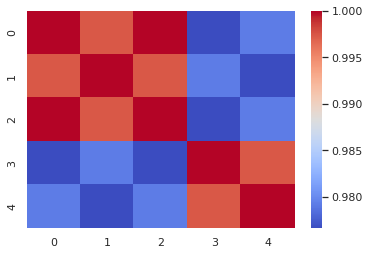

In [70]:
sns.heatmap(result, cmap="coolwarm")

In [79]:
df = pd.DataFrame(result)

In [80]:
df

,0,1,2,3,4
0,1.0000000,0.9974026,1.0000000,0.9766234,0.9792208
1,0.9974026,1.0000000,0.9974026,0.9792208,0.9766234
2,1.0000000,0.9974026,1.0000000,0.9766234,0.9792208
3,0.9766234,0.9792208,0.9766234,1.0000000,0.9974026
4,0.9792208,0.9766234,0.9792208,0.9974026,1.0000000


In [81]:
mask = np.triu(np.ones_like(df.corr(), dtype=bool))

In [82]:
mask

array([[ True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True],
       [False, False,  True,  True,  True],
       [False, False, False,  True,  True],
       [False, False, False, False,  True]])

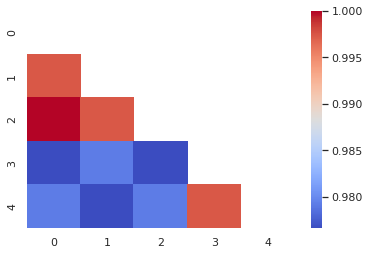

In [83]:
sns.heatmap(df, mask=mask, cmap="coolwarm")